In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import zipfile
zipPath = 'drive/MyDrive/CMAPSSData.zip'

with zipfile.ZipFile(zipPath, 'r') as zipRef:
  zipRef.extractall()

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

## Loading the data into a structure

In [59]:
settings = ['setting_{}'.format(i) for i in range(1,4)]
sensors = ['sensor_{}'.format(i) for i in range(1,22)]
col_names = ["unit_no", "cycles"] + settings + sensors

In [60]:
train= pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)

In [61]:
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names)

Test data is not till failure unlike train data. So for train data the last time series is the time series for failure. For test data the actual Remaining Useful Lifecycles (RUL) are present in corresponding RUL_*.txt file.

In [62]:
test.head()

,unit_no,cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [63]:
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate.

In [64]:
y_test.head()

,RUL
0,112
1,98
2,69
3,82
4,91


### Calculating RUL for train_data

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   unit_no    20631 non-null  int64  
 1   cycles     20631 non-null  int64  
 2   setting_1  20631 non-null  float64
 3   setting_2  20631 non-null  float64
 4   setting_3  20631 non-null  float64
 5   sensor_1   20631 non-null  float64
 6   sensor_2   20631 non-null  float64
 7   sensor_3   20631 non-null  float64
 8   sensor_4   20631 non-null  float64
 9   sensor_5   20631 non-null  float64
 10  sensor_6   20631 non-null  float64
 11  sensor_7   20631 non-null  float64
 12  sensor_8   20631 non-null  float64
 13  sensor_9   20631 non-null  float64
 14  sensor_10  20631 non-null  float64
 15  sensor_11  20631 non-null  float64
 16  sensor_12  20631 non-null  float64
 17  sensor_13  20631 non-null  float64
 18  sensor_14  20631 non-null  float64
 19  sensor_15  20631 non-null  float64
 20  sensor

Nice! All dtype for all the columns is either int or float

In [66]:
last_cycle = train.groupby('unit_no')['cycles'].transform('max')
# transform applies a function to each group separately, and returns a new Series or DataFrame with the same shape as the original input.
train['RUL'] = last_cycle - train['cycles']

In [67]:
train.head()

,unit_no,cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [68]:
train

,unit_no,cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


##EDA

In [69]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit_no,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200


- Need to remove those features which remains constant i.e. 0 standard deviation : setting_3, sensor_1, sensor_10, sensor_18, sensor_19.

- Also need to scale the features.

### RUL distribution

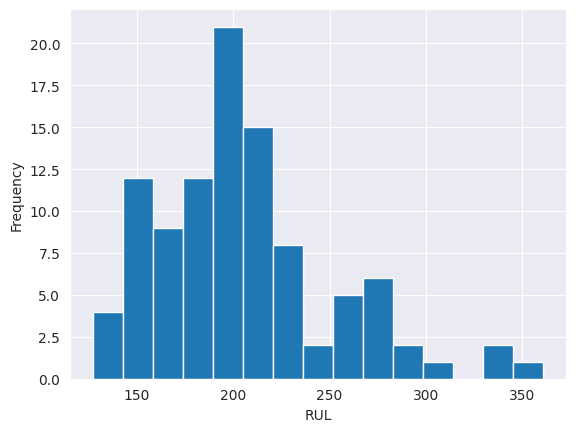

In [70]:
plt.hist(train[["unit_no", "RUL"]].groupby("unit_no").max(), bins=15)
plt.xlabel("RUL")
plt.ylabel("Frequency")
plt.show()

The distribution is right-skewed.

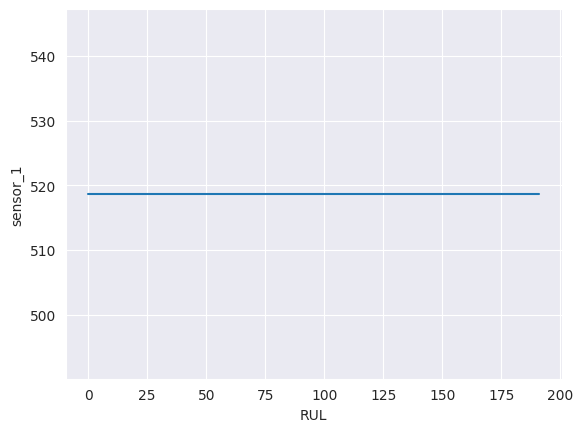

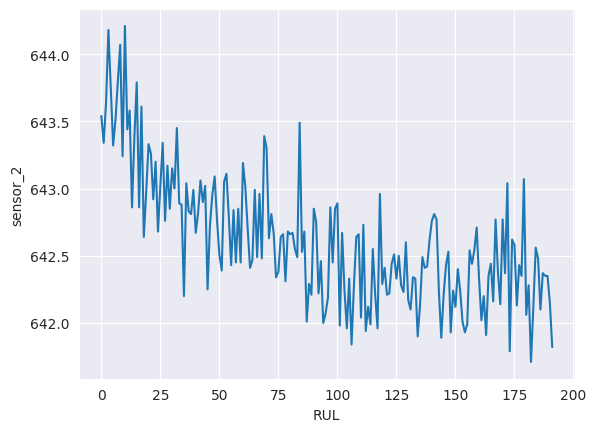

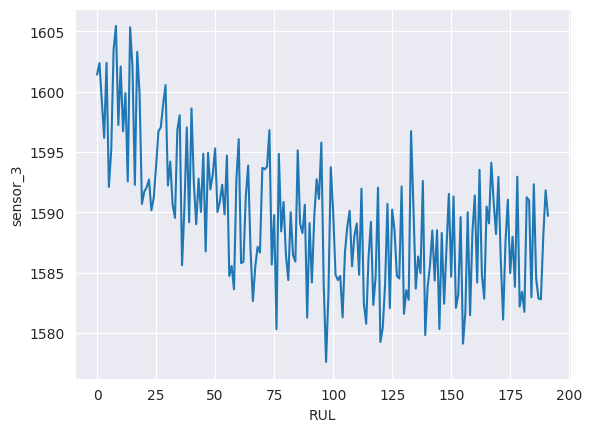

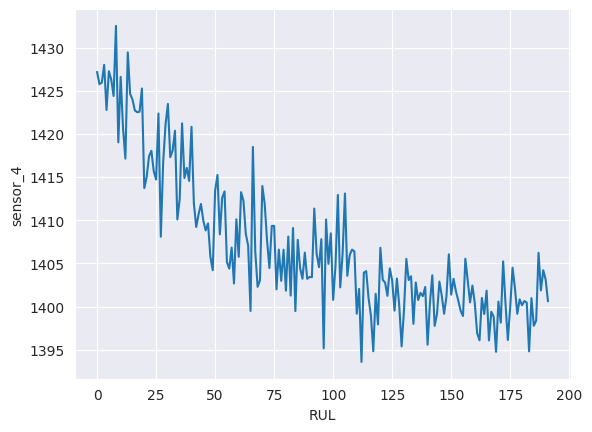

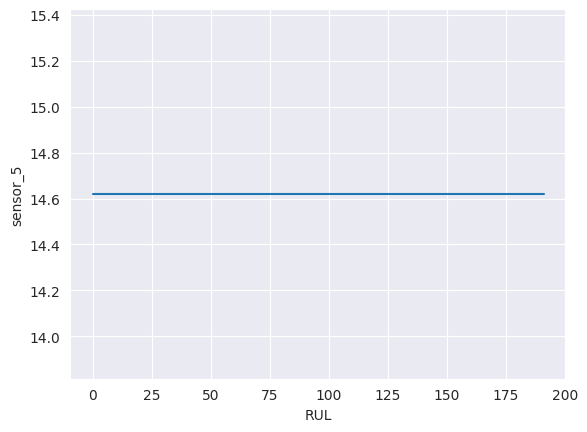

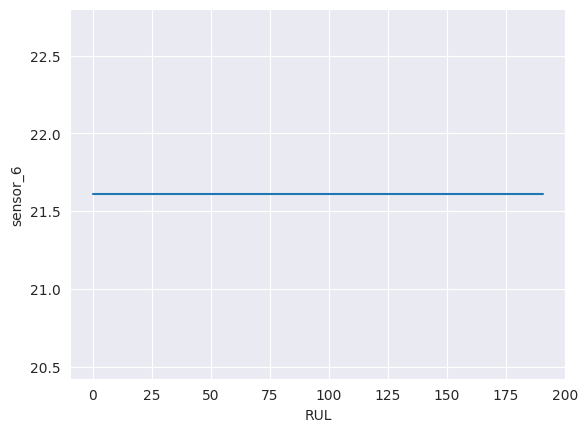

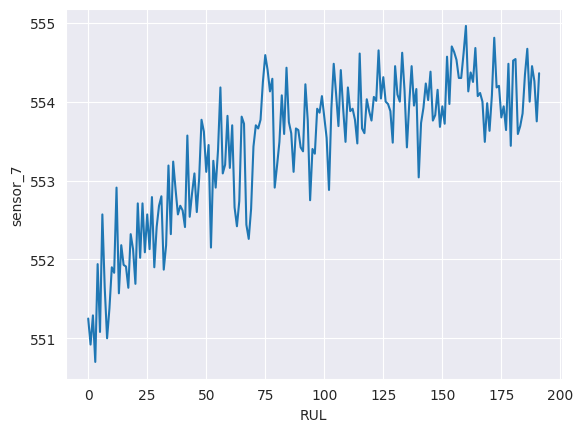

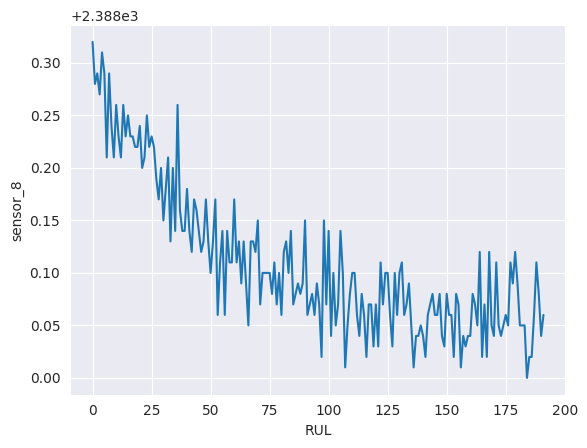

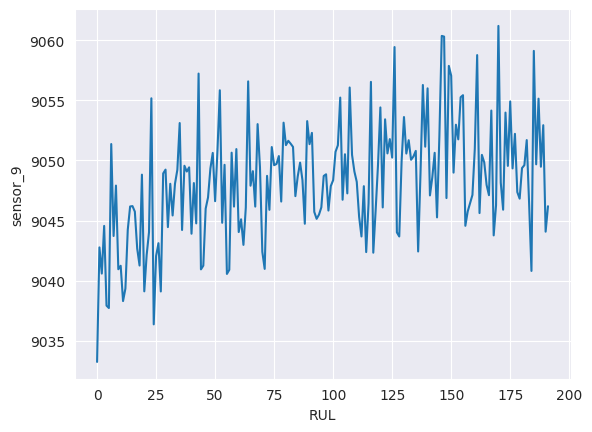

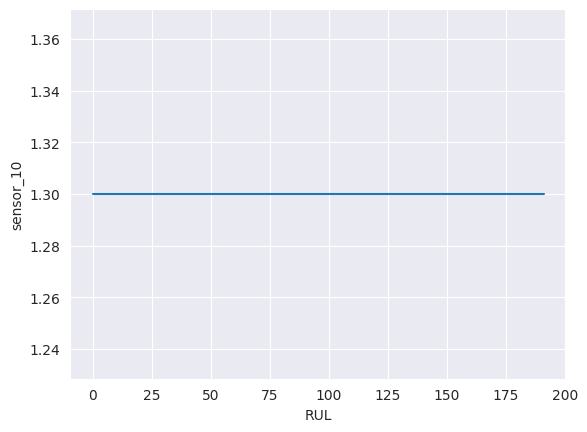

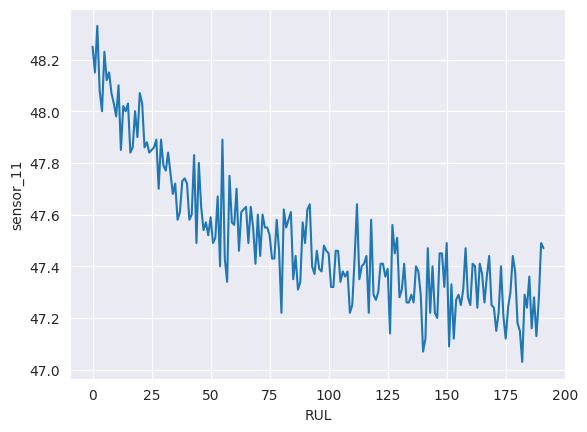

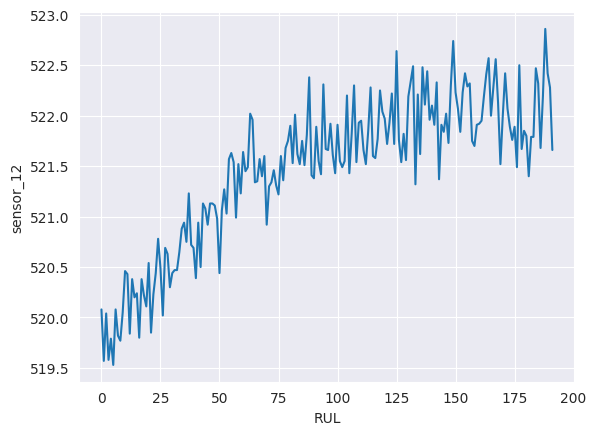

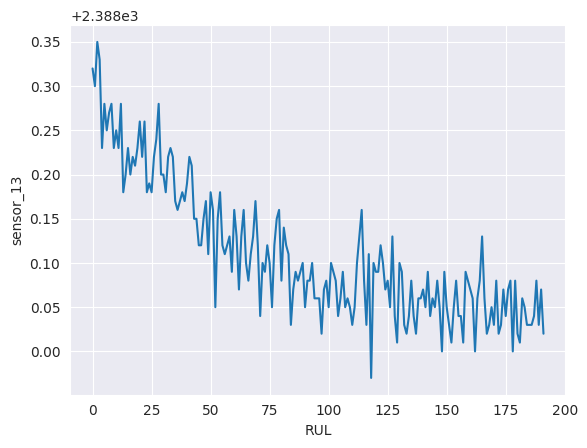

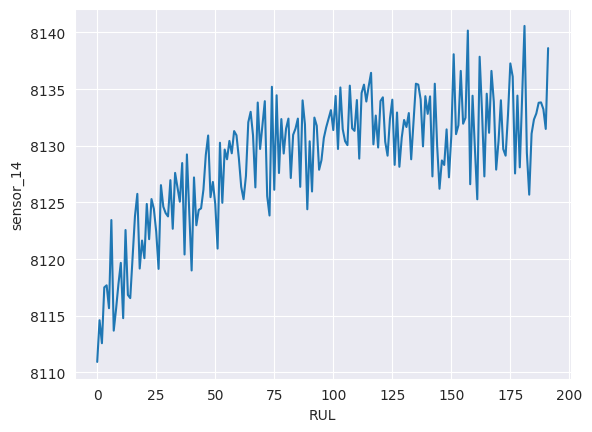

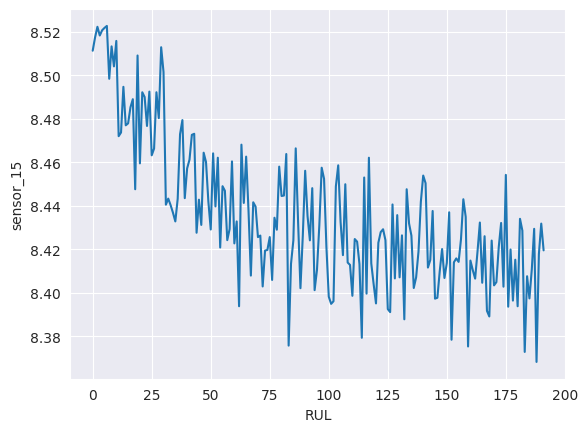

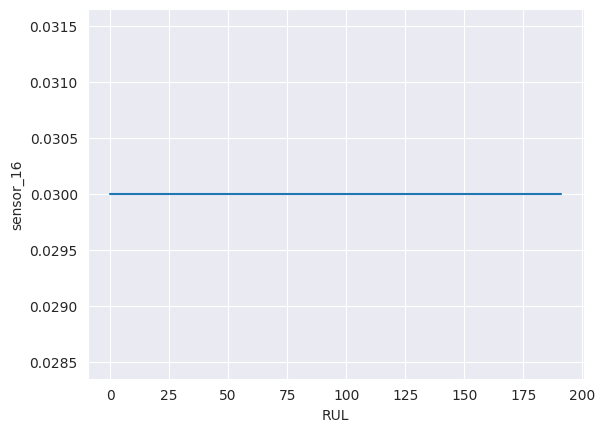

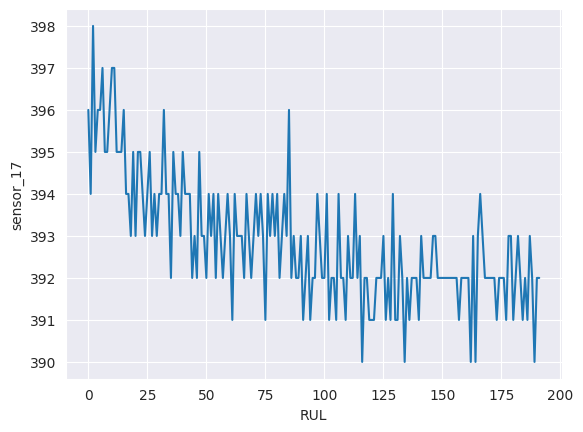

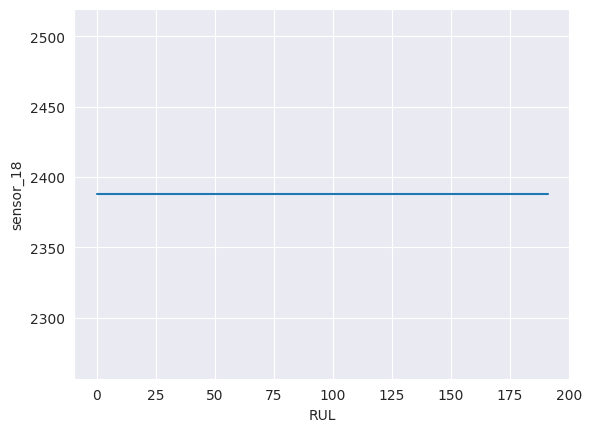

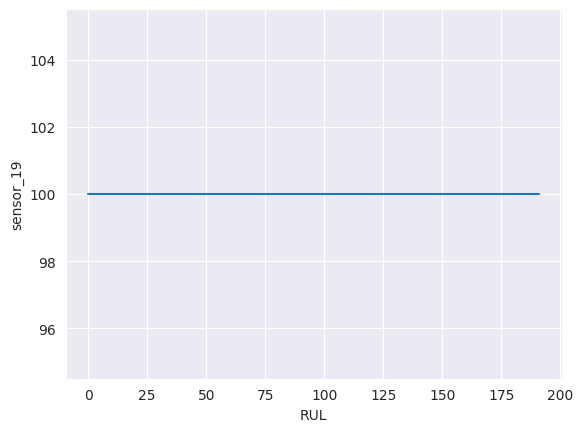

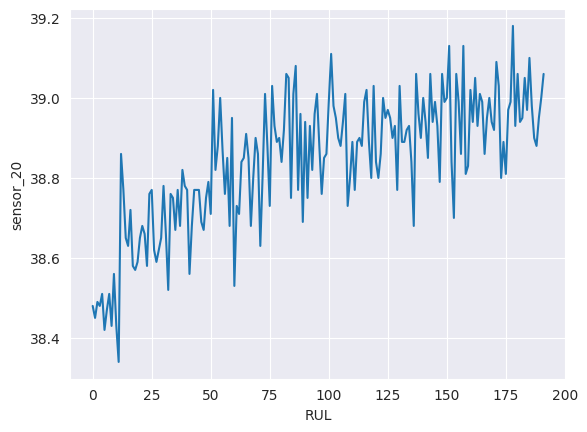

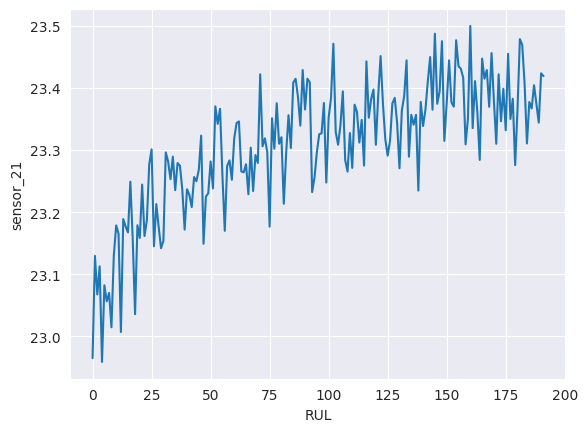

In [71]:
for col in sensors:
  plt.plot(train['RUL'][train['unit_no'] == 1], train[col][train['unit_no'] == 1])
  plt.xlabel('RUL')
  plt.ylabel(col)
  plt.show()

## Baseline Model

In [72]:
train = train.drop(columns = ['setting_3', 'sensor_1', 'sensor_10', 'sensor_18', 'sensor_19'])

In [73]:
y = train['RUL']
X = train.drop(columns=['RUL'])

In [74]:
print(X.shape, y.shape)

(20631, 21) (20631,)


In [75]:
ct = ColumnTransformer([
    ('passthrough', 'passthrough', ['unit_no', 'cycles', 'setting_1', 'setting_2']),
    ('scaling', StandardScaler(), list(set(sensors) - set(['sensor_1', 'sensor_10', 'sensor_18', 'sensor_19'])))
])

In [76]:
X = ct.fit_transform(X)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=72)

In [78]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14441, 21) (6190, 21) (14441,) (6190,)


In [79]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [80]:
def evaluate_model(X, y, model):
  r2 = model.score(X, y)
  rmse = mean_squared_error(y, model.predict(X)) ** 0.5
  print("RMSE:", rmse, "R2:", r2)

In [81]:
evaluate_model(X_train, y_train, lr)
evaluate_model(X_test, y_test, lr)

RMSE: 39.68089852532112 R2: 0.6685644546332886
RMSE: 39.36751463705055 R2: 0.6723031061091834
